# BANA 4143 Python Group 9 Final Project Part 2

## Step 1: Import Packages, Data, and Connect to SQL Server

### Importing Required Packages

In [1]:
#Allows multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#Necessary packages
import pandas as pd              #Data cleaning and manipulation
import numpy as np               #Arithmetic and recoding data
import sqlalchemy as sqla        #Interfacing with SQL Server database
import urllib                    #Establishing connection with SQL Server database
import seaborn as sns            #Visualization
import matplotlib.pyplot as plt  #Visualization overlays and customization

### Importing Data from Excel File

In [3]:
####### MUST CHANGE FILE PATH FOR DIFFERENT USERS ########

#Define file path to the excel data file (vehicle_accidents.xlsx)
file_path = 'vehicle_accidents.xlsx'

#Read in data as a dataframe - only read in the 'accident_data' sheet - metadata sheet is not 
#necessary for our continued analysis
df = pd.read_excel(file_path, sheet_name = 'accident_data')

#Display data
df

,CRASH_DATE,CRASH_TIME,INJURY_RESULT,PERSON_AGE,INJURY_AREA,PERSON_SEX,INJURY_PERSON_TYPE
0,2022-11-16,06:00:00,Killed,80.0,Head,M,Pedestrian
1,2022-11-16,07:00:00,Injured,13.0,Back,F,Occupant
2,2022-11-16,03:00:00,Injured,37.0,Unknown,M,Occupant
3,2022-11-16,07:00:00,Injured,43.0,Chest,M,Occupant
4,2022-11-16,11:00:00,Injured,31.0,Knee-Lower Leg Foot,M,Bicyclist
...,...,...,...,...,...,...,...
45665,2022-01-01,12:00:00,Injured,25.0,Elbow-Lower-Arm-Hand,F,Pedestrian
45666,2022-01-01,00:00:00,Injured,26.0,Knee-Lower Leg Foot,M,Bicyclist
45667,2022-01-01,05:00:00,Injured,28.0,Head,F,Occupant
45668,2022-01-01,01:00:00,Injured,29.0,Back,M,Occupant


### Connecting to SQL Server 

In [4]:
#Define connection details

####################### MUST UPDATE DATABASE, UID, AND PWD TO CONNECT TO YOUR OWN DATABASE ####################
conn_details = urllib.parse.quote_plus("""DRIVER={ODBC Driver 17 for SQL Server};
                                       SERVER=lcb-sql.uccob.uc.edu\DMFA;
                                       DATABASE=LCB-DMFA-005;
                                       UID=LCB-DMFA-005;PWD=PZ$022bd""")

#Create database engine using connection details
db_engine = sqla.create_engine("mssql+pyodbc:///?odbc_connect=%s" % conn_details)

#Connect to server
conn2 = db_engine.connect()

## Step 2: Analyze & Visualize Data 

### Analyzing the number involved, killed, and injured by crash

Not much can be accomplished by running summary statistics on the original dataframe as the only numeric column is 'PERSON_AGE'. Instead we wanted to look at the number of people involved in each crash, as well as the number of people injured and the number of people killed.

In order to conduct this analysis, we must first create a datetime column in order to subset this information by each unique crash. The code to do this is shown below:

In [5]:
#Recode as string to allow for concatenation
df['CRASH_DATE'] = df['CRASH_DATE'].astype(str)
df['CRASH_TIME'] = df['CRASH_TIME'].astype(str)

#Create datetime column from CRASH_DATE & CRASH_TIME
#This is accomplished by concatenating 'CRASH_DATE' & 'CRASH_TIME' and 
#then casting the concatenated string as a datetime data type
df['CRASH_DATETIME'] = pd.to_datetime(df['CRASH_DATE']+' '+ df['CRASH_TIME'])

#Drop 'CRASH_DATE' & 'CRASH_TIME' columns - no longer needed because of our created 'CRASH_DATETIME' column
df = df.drop(['CRASH_DATE','CRASH_TIME'], axis = 1)

Next, we can create our calculated columns in a new dataframe.

In [6]:
#subest df by each unique crash incident
#accomplished by setting the index as the unique crash datetimes
df2 = pd.DataFrame(index = df['CRASH_DATETIME'].unique())

#Number involved calculated as the number of records that have the same crash datetime
df2['num_involved'] = df.groupby('CRASH_DATETIME').size()

#fields calculated by grouping by each crash, filtering by injury result, and taking the size of each
df2['num_killed'] = df[df['INJURY_RESULT'] == 'Killed'].groupby('CRASH_DATETIME').size()
df2['num_injured'] = df[df['INJURY_RESULT'] == 'Injured'].groupby('CRASH_DATETIME').size()

#Convert nan to 0
df2['num_killed'] = df2['num_killed'].replace(np.nan, 0)
df2['num_injured'] = df2['num_injured'].replace(np.nan, 0)

#Convert columns to integer datatype
df2['num_killed'] = df2['num_killed'].astype(int)
df2['num_injured'] = df2['num_injured'].astype(int)

We will now view the summary statistics for this table.

In [7]:
#Display summary statistics
df2.describe()

,num_involved,num_killed,num_injured
count,7100.000000,7100.000000,7100.000000
mean,6.432394,0.035634,6.396761
std,4.358084,0.195016,4.351174
min,1.000000,0.000000,0.000000
25%,3.000000,0.000000,3.000000
50%,6.000000,0.000000,6.000000
75%,9.000000,0.000000,9.000000
max,31.000000,3.000000,31.000000


As we can see from our summary statisics, the average amount of people involved for each crash is right around 6 people. Additionally, we can see that it is quite rare that a crash results in a fatality, with the mean amount of people killed being 0.03 - awfully close to 0. 

Using these measures is nice to gather quick insights; however, there may be additional trends we cannot see because of the influence of outliers. For example, the number of people involved has quite a large range, with the maximum being 31 and the minimum being 1. To get the full story, we will plot the data.

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='num_involved', ylabel='count'>

Text(0.5, 1.0, 'Count of Crashes by Number of People Involved')

Text(0.5, 0, 'Number Involved')

Text(0, 0.5, 'Count of Crashes')

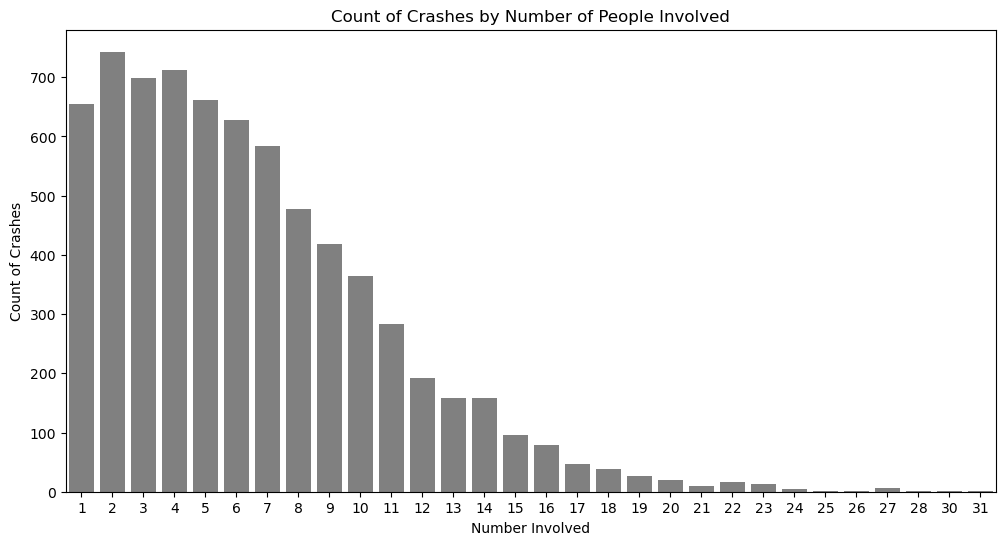

In [8]:
#Resize plot area to spread out axis values
plt.figure(figsize = (12, 6))

#Plot the number involved column from df2 and make the bars gray
sns.countplot(df2, x = 'num_involved', color = 'gray')

#Add figure title and axis titles
plt.title('Count of Crashes by Number of People Involved')
plt.xlabel('Number Involved')
plt.ylabel('Count of Crashes')

#Show plot
plt.show()

We can see that the majority of crashes involve between 1 and 10 people, with the most crashes involving just 2 people. It is surprising to find that around 650 crashes involved just 1 person as well.

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='num_injured', ylabel='count'>

Text(0.5, 1.0, 'Count of Crashes by Number of People Injured')

Text(0.5, 0, 'Number Injured')

Text(0, 0.5, 'Count of Crashes')

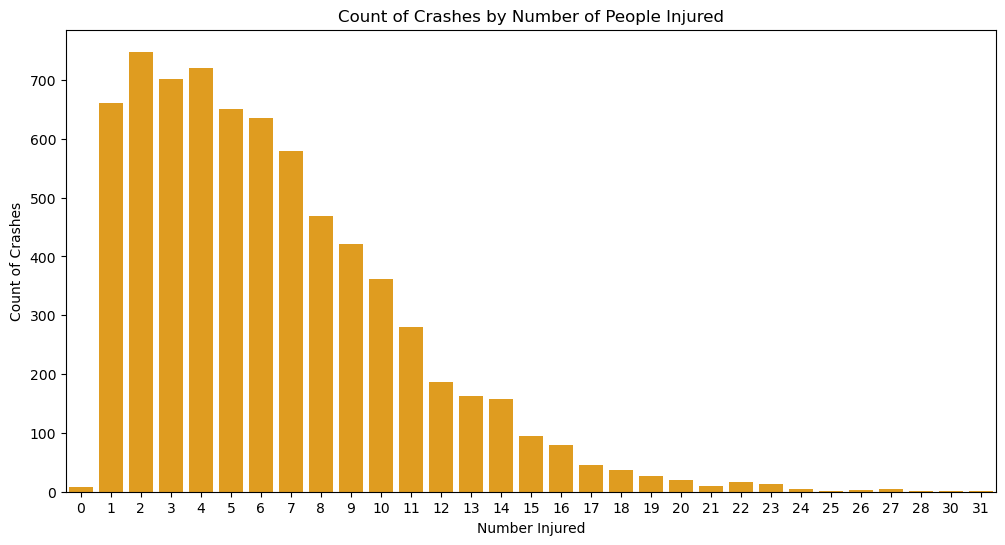

In [9]:
#Resize plot area to spread out axis values
plt.figure(figsize = (12, 6))

#Plot the number injured column from df2 and make the bars orange
sns.countplot(df2, x = 'num_injured', color = 'orange')

#Add figure title and axis titles
plt.title('Count of Crashes by Number of People Injured')
plt.xlabel('Number Injured')
plt.ylabel('Count of Crashes')

#Show plot
plt.show()

We can see that the distribution for the number of people injured closely aligns with the distribution for the number of people involved. This means that it is highly likely that those involved in a crash will sustain at least 1 injury and the vast majority of people involved in a crash will not be killed.

<Axes: xlabel='num_killed', ylabel='count'>

Text(0.5, 1.0, 'Count of Crashes by Number of People Killed')

Text(0.5, 0, 'Number Killed')

Text(0, 0.5, 'Count of Crashes')

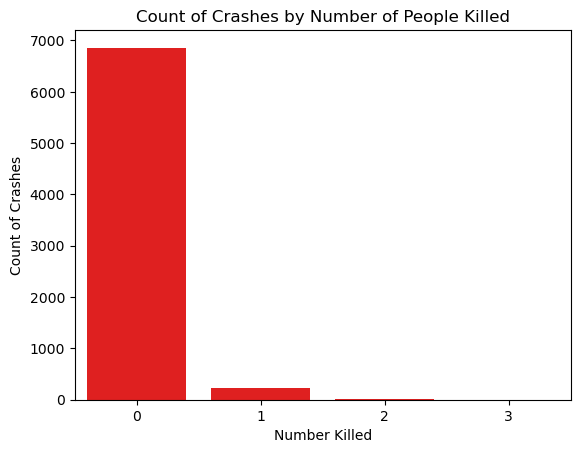

In [10]:
#Plot the number killed column from df2 and make the bars red
sns.countplot(df2, x = 'num_killed', color = 'red')

#Add figure title and axis titles
plt.title('Count of Crashes by Number of People Killed')
plt.xlabel('Number Killed')
plt.ylabel('Count of Crashes')

#Show plot
plt.show()

### Analyzing Injury Areas & Person Type

Considering fatalities seem to be quite rare, we wanted to see which injury areas were most associated with fatalities.

In [11]:
#SQL statement to retrieve a count of the number of fatalities by injury area
fatalities_tbl_cmd = sqla.text(
    """SELECT a.InjuryArea, COUNT(*) AS NumFatalities
    FROM final.Injuries i
    INNER JOIN final.InjuryAreas a
    ON a.InjuryAreaID = i.InjuryAreaID
    WHERE i.Severity = 'Fatal'
    GROUP BY a.InjuryArea
    ORDER BY NumFatalities DESC;""")

#Execute SQL command above and retrieve results
fatalities_tbl = conn2.execute(fatalities_tbl_cmd).fetchall()

#Convert results to DataFrame to make data compatible with Pandas for data manipulation & analysis
fatalities_tbl = pd.DataFrame(fatalities_tbl)

<Axes: xlabel='NumFatalities', ylabel='InjuryArea'>

Text(0.5, 1.0, 'Number of Fatalities by Associated Injury Area')

Text(0.5, 0, 'Number of Fatalities')

Text(0, 0.5, 'Injury Area')

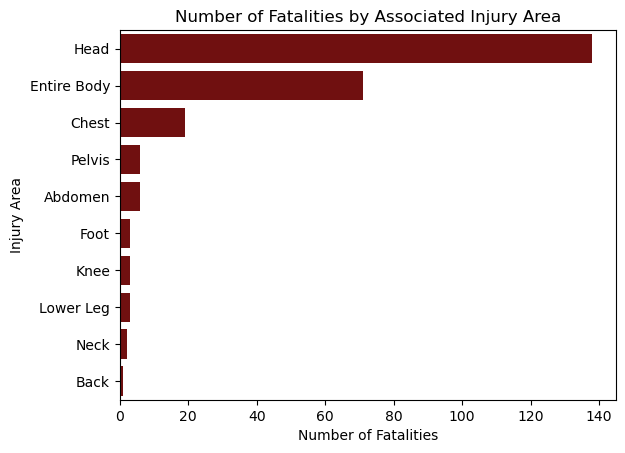

In [12]:
#Create barplot visualizng the number of fatalities by injury area
sns.barplot(fatalities_tbl, x = 'NumFatalities', y = 'InjuryArea', color = 'maroon')

#Add figure title and axis titles
plt.title('Number of Fatalities by Associated Injury Area')
plt.xlabel('Number of Fatalities')
plt.ylabel('Injury Area')

#Show plot
plt.show()

Most fatalities are associated with a head injury, with the second most number of fatalities associated with injuries sustained to the entire body. Obviously, this makes the most sense. It is interesting to see that not every injury area is associated with a fatality though.

We also wanted to look into the number of the different injuries based on the type of person involved in the accident. Based on their role in the accident, we initially thought that each type of person may have different injuries as the most common.

In [13]:
#SQL statement to create a table that shows the number of injuries per area of injury per type of person
ptype_injury_cmd = sqla.text(
    """SELECT p.Type, InjuriesSub.InjuryArea, COUNT(*) AS NumInjuries
    FROM final.People p
    INNER JOIN
        (SELECT i.PersonID, a.InjuryArea
        FROM final.Injuries i
        INNER JOIN final.InjuryAreas a
        ON i.InjuryAreaID = a.InjuryAreaID
        GROUP BY PersonID, InjuryArea) AS InjuriesSub
    ON InjuriesSub.PersonID = p.PersonID
    GROUP BY p.Type, InjuriesSub.InjuryArea;""")

#Execute SQL command above and retrieve results
ptype_injury = conn2.execute(ptype_injury_cmd).fetchall()

#Convert results to DataFrame to make data compatible with Pandas for data manipulation & analysis
ptype_injury_df = pd.DataFrame(ptype_injury)

C:\Users\Zbier\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


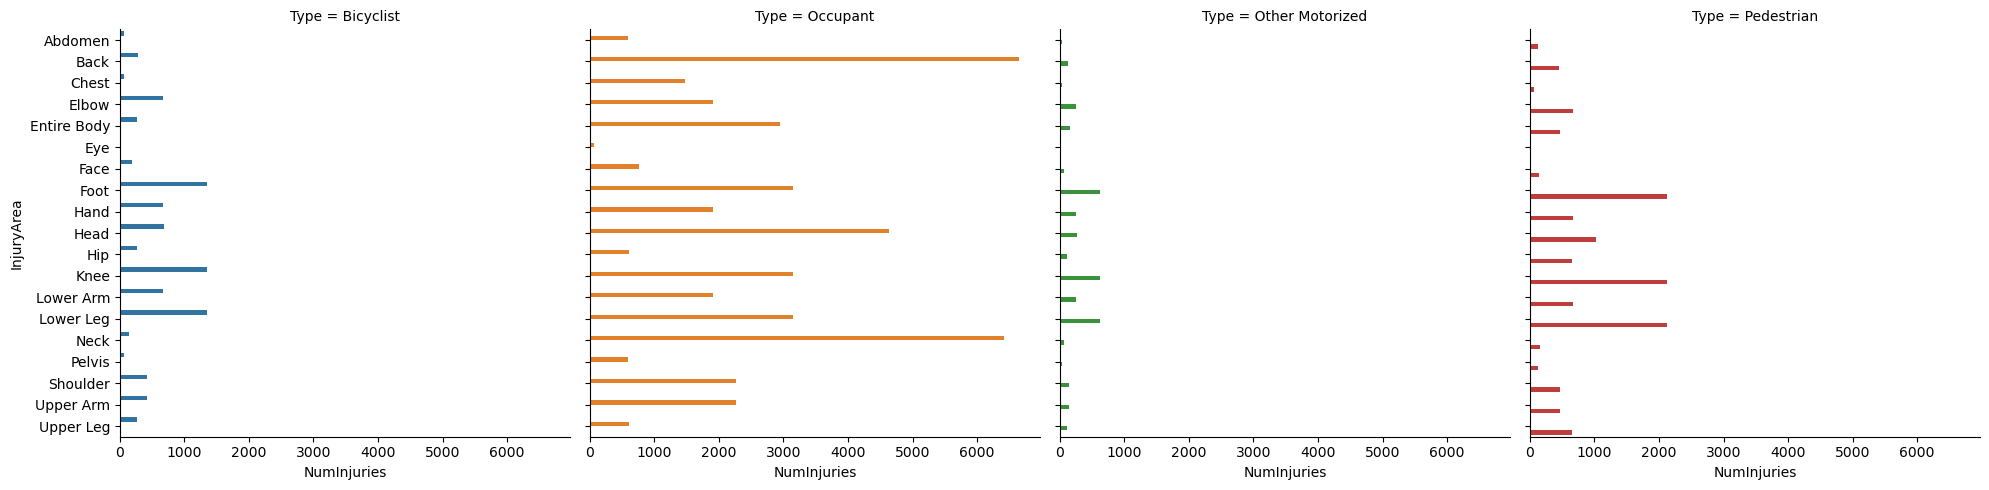

In [14]:
sns.catplot(ptype_injury_df, kind="bar", x="NumInjuries", y="InjuryArea", 
            hue="Type", col="Type")

Based on the visualization above, we can see that:
- a Bicyclist tends to have more foot, knee, or lower leg injuries
- an Occupant tends to have more back and neck injuries
- someone in another motorized vehicle tends to have foot, knee, or lower leg injuries
- a pedestrian tends to have more foot, knee, or lower leg injuries

There are clearly more injuries inflicted on the Occupants than any other category, but it is also interesting that they are the only category that doesn't have foot, knee, or lower leg injuries as their top area of injury. 

The visualization above also made us raise the question, what types of people are involved in more accidents?

In [16]:
#SQL statement to retrieve all rows and columns from People tables
people_tbl_cmd = sqla.text(
    """SELECT * FROM final.People;""")

#Execute SQL command above and retrieve results
people_tbl = conn2.execute(people_tbl_cmd).fetchall()

#Convert results to DataFrame to make data compatible with Pandas for data manipulation & analysis
people_tbl = pd.DataFrame(people_tbl)

#Null values/ages that were not provided were recoded as -999 in our database
#We must reverse this affect to get accurate statistics
#This is done by recoding -999 values to NA which will be omitted from the analysis
people_tbl.loc[(people_tbl['Age'] == -999)] = pd.NA 

C:\Users\Zbier\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Number of People by Type')

Text(0.5, 9.444444444444438, 'Number of People')

Text(-12.805555555555555, 0.5, 'Type')

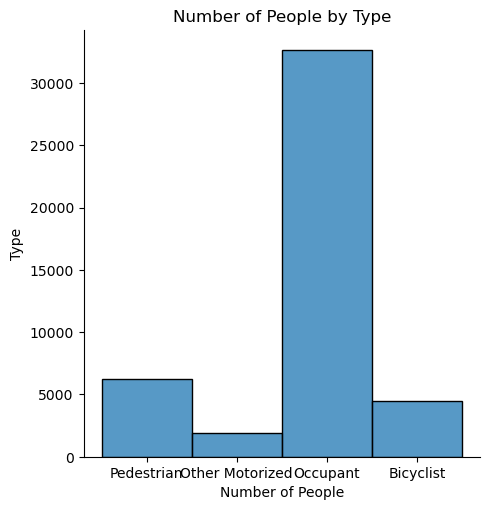

In [17]:
# Histogram takes the People Table to count the number in each type (Pedestrian, Occupant, Bicyclist, and Other Motorized)
sns.displot(people_tbl, x = "Type")

#Add figure title and axis titles
plt.title('Number of People by Type')
plt.xlabel('Number of People')
plt.ylabel('Type')

#Show plot
plt.show()

When asking this question, our assumption was that the Occupant category would have the highest number. This makes sense as the dataset is tracking injuries based on car accidents. What is interesting to see is that there are a higher number of Pedestrians injured than Bicyclists. 

### Analyzing Age & Sex

Another factor we wanted to look at was age. Based off of our intuition, we hypothesized that younger people would account for the highest number of crashes and have the highest involvement in the crashes. In order to answer this question, we first started by looking at the distribution of ages and the number of crashes by each age. 

In [18]:
#Display summary statistics
people_tbl.agg({'Age': ["min", "max", "median", "mean", "skew"]})

,Age
min,0.000000
max,100.000000
median,34.000000
mean,36.774052
skew,0.511902


A boxplot will also help us determine the distribution of ages.

<Axes: xlabel='Age'>

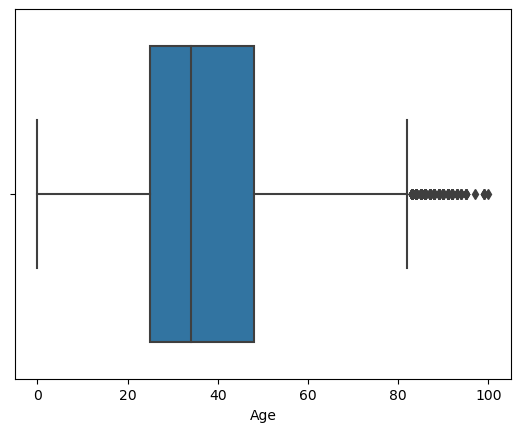

In [19]:
sns.boxplot(people_tbl, x = 'Age')

Now, let's add another dimension to our analysis. We will look at the count of ages involved in crashes by sex.

C:\Users\Zbier\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Count of Ages involved in Crashes by Sex')

Text(0.5, 9.444444444444438, 'Age Bin')

Text(1.8784999999999972, 0.5, 'Count')

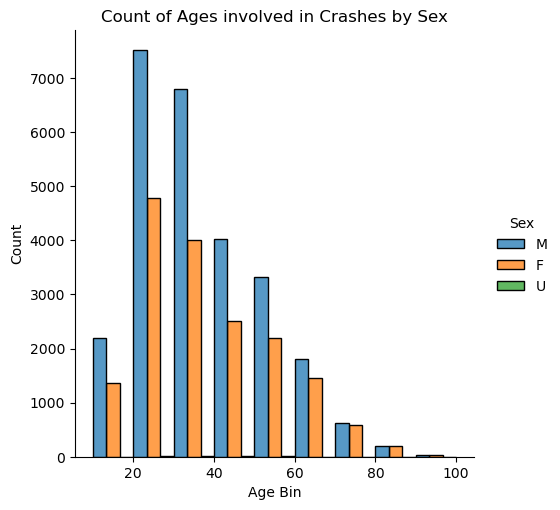

In [20]:
#create bar chart showing the count of crashes for various age groups, comparing female and male as well
sns.displot(people_tbl, x='Age', 
            bins=[10,20,30,40,50,60,70,80,90,100], hue = 'Sex', stat='count', common_norm=False,
           multiple='dodge') 

#Add figure title and axis titles
plt.title('Count of Ages involved in Crashes by Sex')
plt.xlabel('Age Bin')
plt.ylabel('Count')

#Show plot
plt.show()

This visualization shows that people in the age range 20-40 are most commonly involved in crashes. Additionally, males consistently have a greater frequency of crashes than that of females. 

### Analyzing the Effect of Time

Another area to look at is the time of the year in which crashes occur. For our purposes, we will simply look at the month for the crashes. To do so, we execute a query that pulls the month for each crash.

In [22]:
#SQL statement to retrieve the month for each crash
month_tbl_cmd = sqla.text(
"""SELECT DATEPART(month, CrashDateTime) AS crashMonth 
    FROM final.Crashes
    GROUP BY CrashDateTime
    ORDER BY CrashDateTime;""")

#Execute SQL command above and retrieve results
month_tbl = conn2.execute(month_tbl_cmd).fetchall()

#Convert results to DataFrame to make data compatible with Pandas for data manipulation & analysis
month_tbl = pd.DataFrame(month_tbl)

The month values are currently numeric, so we will convert these to month abbreviations for better readability.

In [23]:
#Define dictionary to map month values 
month_dict = {1: 'Jan',
              2: 'Feb',
              3: 'Mar',
              4: 'Apr',
              5: 'May',
              6: 'Jun',
              7: 'Jul',
              8: 'Aug',
              9: 'Sep',
             10: 'Oct',
             11: 'Nov',
             12: 'Dec'}

#Change month from number to month abbreviation by mapping the month_dict to the 'crashMonth' column in the month_tbl
month_tbl = month_tbl['crashMonth'].map(month_dict)

#Convert results to DataFrame to make data compatible with Pandas for data manipulation & analysis
month_tbl = pd.DataFrame(month_tbl)

<Axes: xlabel='crashMonth', ylabel='count'>

Text(0.5, 1.0, 'Number of Crashes by Month')

Text(0.5, 0, 'Number of Crashes')

Text(0, 0.5, 'Month')

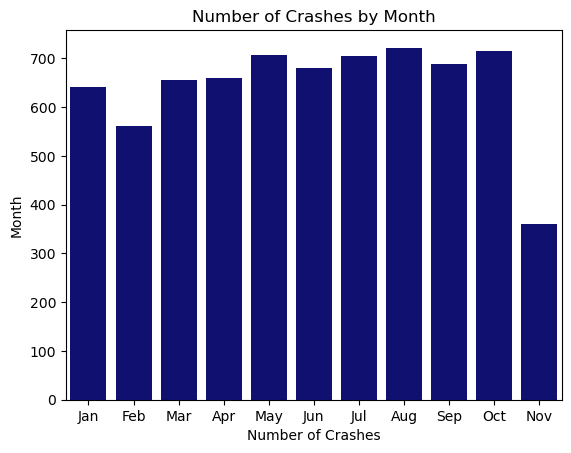

In [24]:
#Create plot showing number of crashes by month
sns.countplot(month_tbl, x = 'crashMonth', color = 'navy')

#Add figure title and axis titles
plt.title('Number of Crashes by Month')
plt.xlabel('Number of Crashes')
plt.ylabel('Month')

#Show plot
plt.show()


We initially hypothesized that weather/seasons may have an effect on the amount of accidents; however, after analyzing the distribution of accidents by month, we can conclude that there is no correlation between the seasonal/weather effect on the number of accidents that occur. 

Perhaps the day of the week has a correlation with the number of crashes. One may suppose that more crashes occur on the weekdays as a result of people commuting to and from work.

In [25]:
#Read in crashes table from SQL
try:
    Crashes_df = pd.read_sql('select * from final.Crashes',conn2)
except Exception as e:
    print(e)

In [26]:
#Get day of the week from datetime field 
Day_of_Week = Crashes_df['CrashDateTime'].dt.dayofweek

#insert the 'Day of Week' column into the dataframe 
Crashes_df.insert(2,"Day of Week", Day_of_Week)

#sort by the day of week
Crashes_df = Crashes_df.sort_values(by = 'Day of Week', ascending = True)

In [27]:
#make a dictionary that maps numbers from function to actual days of the week
Day_of_the_week_conversions = {0: 'Mon', 1: 'Tue', 2:'Wed', 3:'Thu', 4:'Fri',5:'Sat', 6:'Sun'}

#map values from dictionary to 'Day of Week' column
Crashes_df = Crashes_df['Day of Week'].map(Day_of_the_week_conversions)

#convert to dataframe
Crashes_df = pd.DataFrame(Crashes_df)

C:\Users\Zbier\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Number of Crashes by Day of Week')

Text(0.5, 9.444444444444438, 'Number of Crashes')

Text(-3.9305555555555554, 0.5, 'Day of Week')

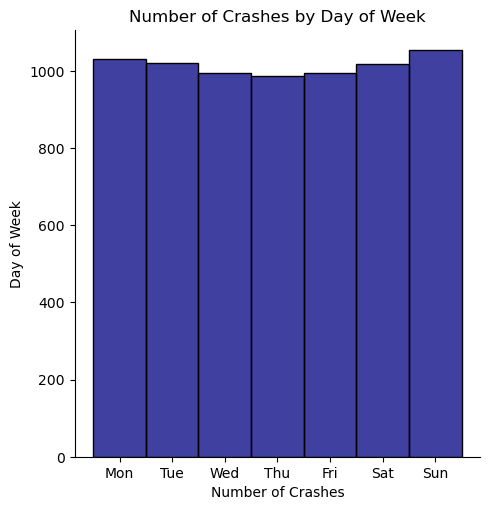

In [28]:
#create a bar chart showing count of crashes per day of week
sns.displot(Crashes_df, x='Day of Week', color = 'navy')  

#Add figure title and axis titles
plt.title('Number of Crashes by Day of Week')
plt.xlabel('Number of Crashes')
plt.ylabel('Day of Week')

#Show plot
plt.show()

The day of the week also seems to have little affect on the number of crashes.

### Summary

From our analysis we have concluded that the majority of crashes involve around 1-10 people, and the majority of people involved sustain at least 1 injury; however, it is quite rare that a crash will result in a fatality. The most common injury areas associated with fatalities are the head, entire body and chest. Additionally, young to middle aged adults account for the most crashes, and men are involved in more crashes than women. The majority of people involved in crashes are occupants, and they sustain neck and back injuries most often. Finally, the time of year and day of week appear to have no reasonable effect on the amount of crashes that occur.

### Close Database Connection

In [29]:
#Close connection
conn2.close() 

#Close engine
db_engine.dispose() 